In [1]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import Sampler
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver

import numpy as np
import matplotlib.pyplot as plt
from qiskit_algorithms.optimizers import COBYLA

In [2]:
colors = ["red", "green", "blue", "white"]
cubes = [
    [("red", "green"), ("green", "white"), ("blue", "blue")],
    [("red", "red"), ("green", "white"), ("red", "blue")],
    [("red", "green"), ("green", "white"), ("blue", "white")],
    [("red", "blue"), ("green", "white"), ("blue", "white")],
]

/var/folders/53/xfcz6jxj1bd40h0b5lx9z7xw0000gn/T/ipykernel_26596/1440895562.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


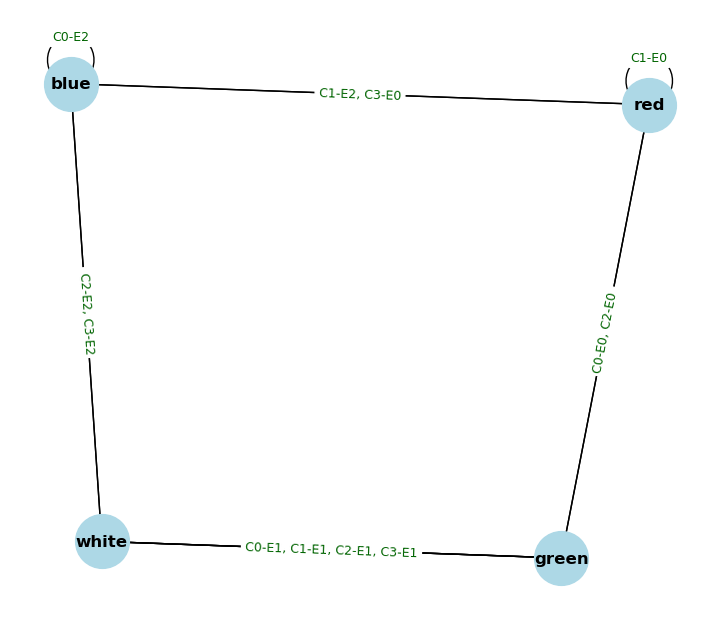

In [3]:
import networkx as nx
from collections import defaultdict

master_graph = nx.MultiGraph()
label_dict = defaultdict(list)

for cube_idx, cube_edges in enumerate(cubes):
    for edge_idx, (color1, color2) in enumerate(cube_edges):
        color1, color2 = sorted([color1, color2])
        label = f"C{cube_idx}-E{edge_idx}"
        master_graph.add_edge(color1, color2, label=label)
        label_dict[(color1, color2)].append(label)

edge_labels = {edge: ", ".join(labels) for edge, labels in label_dict.items()}

pos = nx.spring_layout(master_graph, seed=42)
plt.figure(figsize=(7, 6))
nx.draw(
    master_graph,
    pos,
    with_labels=True,
    node_size=1500,
    node_color="lightblue",
    font_weight="bold",
)

nx.draw_networkx_edge_labels(
    master_graph, pos, edge_labels=edge_labels, font_color="darkgreen", font_size=9
)

plt.axis("off")
plt.tight_layout()
plt.show()

In [4]:
qp = QuadraticProgram("ii")

variables = {}  # ---> x_(g,i.j) == 1 if edge i of cube j is in the subgraph g

for g in ["g1", "g2"]:
    for i in range(len(cubes)):
        for j in range(len(cubes[i])):
            var = f"x_({(g, i, j)})"
            qp.binary_var(var)
            variables[(g, i, j)] = var

# ---- Constraint 1 : Each subgraphs should have only one edge from all the cubes ----
#      for each g and each i it has to satisfy "x_(g, i, 0) + x_(g, i, 1) + x_(g, i, 2) == 1"
#      equality constraint --> make this into the objective function
qp.minimize(constant=0, linear={}, quadratic={})

for g in ["g1", "g2"]:
    for i in range(len(cubes)):
        var_names = [variables[(g, i, j)] for j in range(3)]
        x0, x1, x2 = var_names

        qp.objective.constant += 1
        for v in var_names:
            qp.objective.linear[v] += -1
        qp.objective.quadratic[(x0, x1)] += 2
        qp.objective.quadratic[(x0, x2)] += 2
        qp.objective.quadratic[(x1, x2)] += 2


# ---- Constraint 2 : degree of all the vertices must be 2 ----
#
for g in ["g1", "g2"]:
    for color in colors:
        vars_with_color = []

        for i, cube in enumerate(cubes):
            for j, (c1, c2) in enumerate(cube):
                if color in (c1, c2):
                    vars_with_color.append(variables[(g, i, j)])

        qp.objective.constant += 4

        for v in vars_with_color:
            qp.objective.linear[v] += -3

        for i1 in range(len(vars_with_color)):
            for i2 in range(i1 + 1, len(vars_with_color)):
                v1 = vars_with_color[i1]
                v2 = vars_with_color[i2]
                qp.objective.quadratic[(v1, v2)] += 2

# ---- Constraint 3 : subgraphs g1 and g2 must be disjoint subgraphs of the master graph -----
#      x_(g1,i,j) + x_(g2,i,j) <= 1
for i in range(len(cubes)):
    for j in range(len(cubes[i])):
        var_g1 = variables[("g1", i, j)]
        var_g2 = variables[("g2", i, j)]

        qp.linear_constraint(
            linear={var_g1: 1, var_g2: 1}, sense="<=", rhs=1, name=f"dis_{i}_{j}"
        )


print(qp.prettyprint())

Problem name: ii

Minimize
  4*x_(('g1', 0, 0))*x_(('g1', 0, 1)) + 2*x_(('g1', 0, 0))*x_(('g1', 0, 2))
  + 2*x_(('g1', 0, 0))*x_(('g1', 1, 0)) + 2*x_(('g1', 0, 0))*x_(('g1', 1, 1))
  + 2*x_(('g1', 0, 0))*x_(('g1', 1, 2)) + 4*x_(('g1', 0, 0))*x_(('g1', 2, 0))
  + 2*x_(('g1', 0, 0))*x_(('g1', 2, 1)) + 2*x_(('g1', 0, 0))*x_(('g1', 3, 0))
  + 2*x_(('g1', 0, 0))*x_(('g1', 3, 1)) + 2*x_(('g1', 0, 1))*x_(('g1', 0, 2))
  + 4*x_(('g1', 0, 1))*x_(('g1', 1, 1)) + 2*x_(('g1', 0, 1))*x_(('g1', 2, 0))
  + 4*x_(('g1', 0, 1))*x_(('g1', 2, 1)) + 2*x_(('g1', 0, 1))*x_(('g1', 2, 2))
  + 4*x_(('g1', 0, 1))*x_(('g1', 3, 1)) + 2*x_(('g1', 0, 1))*x_(('g1', 3, 2))
  + 2*x_(('g1', 0, 2))*x_(('g1', 1, 2)) + 2*x_(('g1', 0, 2))*x_(('g1', 2, 2))
  + 2*x_(('g1', 0, 2))*x_(('g1', 3, 0)) + 2*x_(('g1', 0, 2))*x_(('g1', 3, 2))
  + 2*x_(('g1', 1, 0))*x_(('g1', 1, 1)) + 4*x_(('g1', 1, 0))*x_(('g1', 1, 2))
  + 2*x_(('g1', 1, 0))*x_(('g1', 2, 0)) + 2*x_(('g1', 1, 0))*x_(('g1', 3, 0))
  + 2*x_(('g1', 1, 1))*x_(('g1', 1, 2))

In [5]:
from qiskit_optimization.converters import QuadraticProgramToQubo

# Convert QP to QUBO and then to Ising
qubo = QuadraticProgramToQubo().convert(qp)
ham, offset = qubo.to_ising()  # <--- use this as `ham`

In [6]:
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from typing import List
from qiskit_aer import AerSimulator
from qiskit import transpile
import time
import pandas as pd
from qiskit_ionq import IonQProvider

num_qubits = ham.num_qubits
ansatz = EfficientSU2(num_qubits, reps=1)

simulator = AerSimulator()
transpiled_ansatz = transpile(ansatz, backend=simulator)

In [10]:
class QITEvolver:
    """
    A class to evolve a parametrized quantum state under the action of an Ising
    Hamiltonian according to the variational Quantum Imaginary Time Evolution
    (QITE) principle described in IonQ's latest joint paper with ORNL.
    """

    def __init__(self, hamiltonian: SparsePauliOp, ansatz: QuantumCircuit):
        self.hamiltonian = hamiltonian
        self.ansatz = ansatz

        # Define some constants
        self.backend = AerSimulator()
        self.num_shots = 10000
        self.energies, self.param_vals, self.runtime = list(), list(), list()

    def evolve(self, num_steps: int, lr: float = 0.4, verbose: bool = True):
        """
        Evolve the variational quantum state encoded by ``self.ansatz`` under
        the action of ``self.hamiltonian`` according to varQITE.
        """
        curr_params = np.zeros(self.ansatz.num_parameters)
        for k in range(num_steps):
            # Get circuits and measure on backend
            iter_qc = self.get_iteration_circuits(curr_params)
            job = self.backend.run(iter_qc, shots=self.num_shots)
            q0 = time.time()
            measurements = job.result().get_counts()
            quantum_exec_time = time.time() - q0

            # Update parameters-- set up defining ODE and step forward
            Gmat, dvec, curr_energy = self.get_defining_ode(measurements)
            dcurr_params = np.linalg.lstsq(Gmat, dvec, rcond=1e-2)[0]
            curr_params += lr * dcurr_params

            # Progress checkpoint!
            if verbose:
                self.print_status(measurements)
            self.energies.append(curr_energy)
            self.param_vals.append(curr_params.copy())
            self.runtime.append(quantum_exec_time)

    def get_defining_ode(self, measurements: List[dict[str, int]]):
        """
        Construct the dynamics matrix and load vector defining the varQITE
        iteration.
        """
        # Load sampled bitstrings and corresponding frequencies into NumPy arrays
        dtype = np.dtype([("states", int, (self.ansatz.num_qubits,)), ("counts", "f")])
        measurements = [
            np.fromiter(map(lambda kv: (list(kv[0]), kv[1]), res.items()), dtype)
            for res in measurements
        ]

        # Set up the dynamics matrix by computing the gradient of each Pauli word
        # with respect to each parameter in the ansatz using the parameter-shift rule
        pauli_terms = [
            SparsePauliOp(op)
            for op, _ in self.hamiltonian.label_iter()
            if set(op) != set("I")
        ]
        Gmat = np.zeros((len(pauli_terms), self.ansatz.num_parameters))
        for i, pauli_word in enumerate(pauli_terms):
            for j, jth_pair in enumerate(zip(measurements[1::2], measurements[2::2])):
                for pm, pm_shift in enumerate(jth_pair):
                    Gmat[i, j] += (-1) ** pm * expected_energy(pauli_word, pm_shift)

        # Set up the load vector
        curr_energy = expected_energy(self.hamiltonian, measurements[0])
        dvec = np.zeros(len(pauli_terms))
        for i, pauli_word in enumerate(pauli_terms):
            rhs_op_energies = get_ising_energies(pauli_word, measurements[0]["states"])
            rhs_op_energies *= (
                get_ising_energies(self.hamiltonian, measurements[0]["states"])
                - curr_energy
            )
            dvec[i] = (
                -np.dot(rhs_op_energies, measurements[0]["counts"]) / self.num_shots
            )
        return Gmat, dvec, curr_energy

    def get_iteration_circuits(self, curr_params: np.array):
        """
        Get the bound circuits that need to be evaluated to step forward
        according to QITE.
        """
        # Use this circuit to estimate your Hamiltonian's expected value
        circuits = [self.ansatz.assign_parameters(curr_params)]

        # Use these circuits to compute gradients
        for k in np.arange(curr_params.shape[0]):
            for j in range(2):
                pm_shift = curr_params.copy()
                pm_shift[k] += (-1) ** j * np.pi / 2
                circuits += [self.ansatz.assign_parameters(pm_shift)]

        # Add measurement gates and return
        [qc.measure_all() for qc in circuits]
        return circuits

    def plot_convergence(self):
        """
        Plot the convergence of the expected value of ``self.hamiltonian`` with
        respect to the (imaginary) time steps.
        """
        plt.plot(self.energies)
        plt.xlabel("(Imaginary) Time step")
        plt.ylabel("Hamiltonian energy")
        plt.title("Convergence of the expected energy")

    def print_status(self, measurements):
        """
        Print summary statistics describing a QITE run.
        """
        stats = pd.DataFrame(
            {
                "curr_energy": self.energies,
                "num_circuits": [len(measurements)] * len(self.energies),
                "quantum_exec_time": self.runtime,
            }
        )
        stats.index.name = "step"
        # display.clear_output(wait=True)
        # display.display(stats)

In [8]:
def compute_cut_size(graph, bitstring):
    """
    Get the cut size of the partition of ``graph`` described by the given
    ``bitstring``.
    """
    cut_sz = 0
    for u, v in graph.edges:
        if bitstring[u] != bitstring[v]:
            cut_sz += 1
    return cut_sz


def get_ising_energies(operator: SparsePauliOp, states: np.array):
    """
    Get the energies of the given Ising ``operator`` that correspond to the
    given ``states``.
    """
    # Unroll Hamiltonian data into NumPy arrays
    paulis = np.array([list(ops) for ops, _ in operator.label_iter()]) != "I"
    coeffs = operator.coeffs.real

    # Vectorized energies computation
    energies = (-1) ** (states @ paulis.T) @ coeffs
    return energies


def expected_energy(hamiltonian: SparsePauliOp, measurements: np.array):
    """
    Compute the expected energy of the given ``hamiltonian`` with respect to
    the observed ``measurement``.

    The latter is assumed to by a NumPy records array with fields ``states``
    --describing the observed bit-strings as an integer array-- and ``counts``,
    describing the corresponding observed frequency of each state.
    """
    energies = get_ising_energies(hamiltonian, measurements["states"])
    return np.dot(energies, measurements["counts"]) / measurements["counts"].sum()


def interpret_solution(graph, bitstring):
    """
    Visualize the given ``bitstring`` as a partition of the given ``graph``.
    """
    pos = nx.spring_layout(graph, seed=42)
    set_0 = [i for i, b in enumerate(bitstring) if b == "0"]
    set_1 = [i for i, b in enumerate(bitstring) if b == "1"]

    plt.figure(figsize=(4, 4))
    nx.draw_networkx_nodes(
        graph, pos=pos, nodelist=set_0, node_color="blue", node_size=700
    )
    nx.draw_networkx_nodes(
        graph, pos=pos, nodelist=set_1, node_color="red", node_size=700
    )

    cut_edges = []
    non_cut_edges = []
    for u, v in graph.edges:
        if bitstring[u] != bitstring[v]:
            cut_edges.append((u, v))
        else:
            non_cut_edges.append((u, v))

    nx.draw_networkx_edges(
        graph, pos=pos, edgelist=non_cut_edges, edge_color="gray", width=2
    )
    nx.draw_networkx_edges(
        graph, pos=pos, edgelist=cut_edges, edge_color="green", width=2, style="dashed"
    )

    nx.draw_networkx_labels(graph, pos=pos, font_color="white", font_weight="bold")
    plt.axis("off")
    plt.show()

CPU times: user 17h 1min 34s, sys: 54min 53s, total: 17h 56min 27s
Wall time: 1h 54min 44s


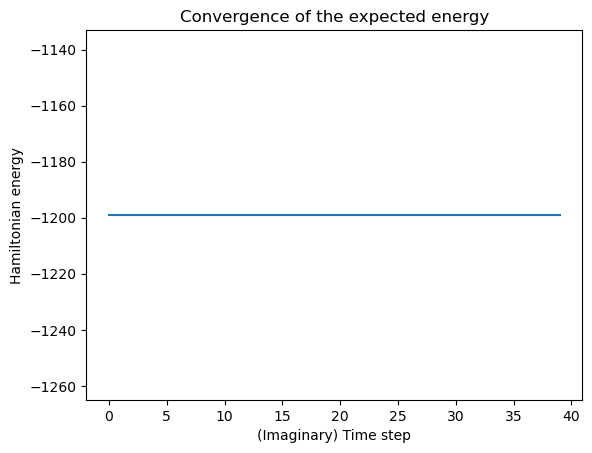

In [11]:
%%time

# Set up your QITEvolver and evolve! You can change number of steps (num_steps) and learning rate (lr)
qit_evolver = QITEvolver(ham, transpiled_ansatz)
qit_evolver.evolve(num_steps=40, lr=0.5, verbose=True) # lr was 0.5

# Visualize your results!
qit_evolver.plot_convergence()